In [34]:
import pandas as pd
import numpy as np
import os
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
# plt.ioff()
from matplotlib.animation import FuncAnimation
import json
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

BASEPATH = os.path.dirname(os.getcwd()).split('main')[0]
sys.path.append(BASEPATH)

from src.models import ScaledModel, WeightedMSELoss
from src.dataloader import AeroDataset
from src.plotting import create_grid

# set plt to inline
%matplotlib inline

DATAPATH = os.path.join(BASEPATH, 'data')
NETWORKPATH = os.path.join(DATAPATH, 'networks')
VISUPATH = os.path.join(DATAPATH, 'visualisation')


In [35]:
from numpy import polyfit

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
BATCH_SIZE = 256
EPOCHS = 200
PATIENCE = 2
LEARNING_RATE = 0.1
MOMENTUM = 0.7
SCALING = False
DATA_DIR = os.path.join(BASEPATH, 'data', 'processed')
MODEL_DIR = os.path.join(DATA_DIR, 'models')

num_workers = 0# if DEVICE == 'cpu' else 4

In [36]:
def prepare_datasets(scaling=False, input_features=None, output_features=None):
    if input_features is None:
        input_features = ['q','alpha','beta','ailerons','elevator']
    if output_features is None:
        output_features = ['CD', 'CY', 'CL', 'Cl', 'Cm', 'Cn']
    
    scaler, output_scaler = (StandardScaler(), StandardScaler()) if scaling else (None, None)
    dataset = AeroDataset(DATA_DIR, input_features, output_features, scaler, output_scaler)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    return random_split(dataset, [train_size, test_size]), scaler, output_scaler

In [37]:

print(f'Using device: {DEVICE}')
input_features = ['q','alpha','beta','aileron','elevator']
output_features = ['CX', 'CY', 'CZ', 'Cl', 'Cm', 'Cn']
(train_dataset, test_dataset), scaler, output_scaler = prepare_datasets(SCALING, input_features, output_features)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# get input and output scales for normalization
inp_scaler = StandardScaler()
out_scaler = StandardScaler()

train_data = train_dataset.dataset.data
inp_scaler.fit(train_data[input_features].values)
out_scaler.fit(train_data[output_features].values)

scaler = (inp_scaler.mean_, inp_scaler.scale_, out_scaler.mean_, out_scaler.scale_)

Using device: mps
         q     alpha      beta  aileron  elevator  windtunnel        CX  \
0  3001.25 -0.087266  0.174533      2.0       2.0        True -0.087399   
1  1531.25 -0.000000 -0.174533      5.0       5.0        True -0.038848   
2   551.25  0.174533 -0.174533      4.0       5.0        True -0.203585   
3  1531.25  0.087266  0.174533      2.0      -2.0        True -0.060623   
4  1531.25 -0.000000 -0.087266     -0.0       5.0        True -0.020356   

         CY        CZ        Cl        Cm        Cn  
0 -0.046691 -0.665836  0.027545 -0.378136 -0.010653  
1  0.037028 -0.210403 -0.095272  0.024250  0.009220  
2  0.049501  0.591954 -0.007918  0.191247  0.003984  
3 -0.040160  0.383961 -0.062236  0.110261 -0.005933  
4  0.015233 -0.206011 -0.026158 -0.267098  0.003406  


/Users/grosche/Documents/GitHub/AIrcraft/src/dataloader.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataset = pd.concat([dataset, temp[self.input_features + self.output_features]], axis=0)


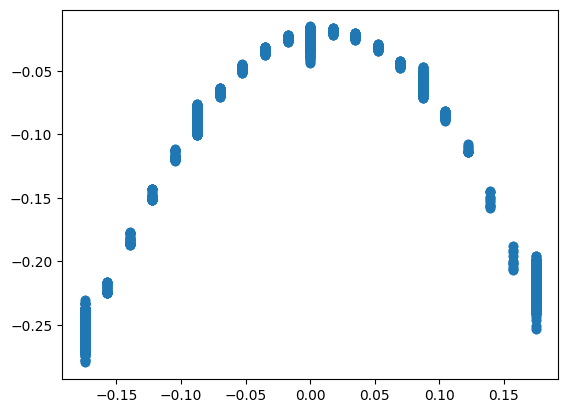

In [39]:
# plot of CX vs alpha

plt.scatter(train_data['alpha'], train_data['CX'])

/var/folders/xb/ljb_b9513718vvdfz5dswxgh0000gp/T/ipykernel_97914/2258213454.py:16: RankWarning: Polyfit may be poorly conditioned
  f.append(np.polyfit(X[i], Y - sum_func(f, X), 5))


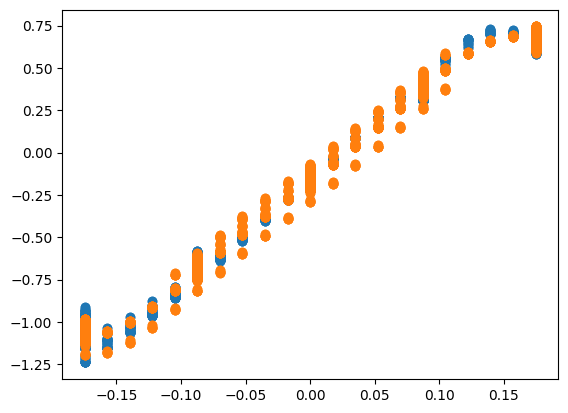

In [69]:
# fit drag with a 3rd order polynomial

X = train_data
Y = train_data['CZ']
f = []

def sum_func(f, x):
    res = 0
    for i, entry in enumerate(f):
        entry = np.poly1d(entry)
        res += entry(x[input_features[i]])

    return res

for i in input_features:
    f.append(np.polyfit(X[i], Y - sum_func(f, X), 5))

plt.scatter(X['alpha'], Y)
plt.scatter(X['alpha'], sum_func(f, X))

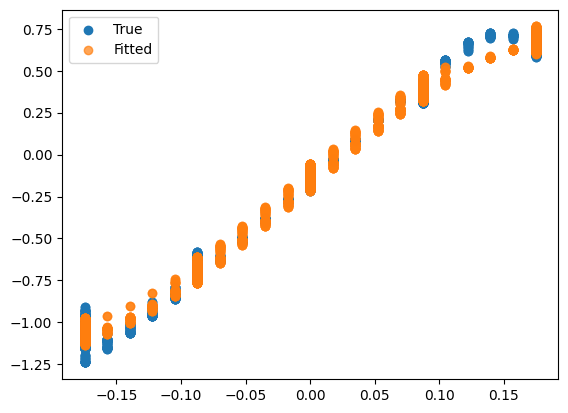

In [71]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
import pickle

# Assuming `train_data` is your DataFrame
X = train_data[input_features]  # Input features as a DataFrame
output_features = ['CX', 'CY', 'CZ', 'Cl', 'Cm', 'Cn']  # Outputs
poly_order = 3  # Polynomial order
fitted_models = {}

# Define symbolic variables for CasADi
casadi_vars = {feat: ca.MX.sym(feat) for feat in input_features}

def fit_polynomials(X, Y, input_features, poly_order):
    """Fits a polynomial model for each input feature."""
    f = []
    for i in input_features:
        residual = Y - sum_func(f, X)
        f.append(np.polyfit(X[i], residual, poly_order))
    return f

def sum_func(f, x):
    """Evaluates the sum of polynomial functions for the given input data."""
    res = 0
    for i, coeffs in enumerate(f):
        res += np.polyval(coeffs, x[input_features[i]])
    return res

def create_casadi_function(f, casadi_vars):
    """Creates a CasADi symbolic function from polynomial coefficients."""
    symbolic_expr = 0
    for i, coeffs in enumerate(f):
        poly_expr = sum(c * casadi_vars[input_features[i]]**(len(coeffs) - j - 1) 
                        for j, c in enumerate(coeffs))
        symbolic_expr += poly_expr
    return symbolic_expr

# Fit models and create CasADi functions
for output in output_features:
    Y = train_data[output]
    f = fit_polynomials(X, Y, input_features, poly_order)
    symbolic_expr = create_casadi_function(f, casadi_vars)
    casadi_func = ca.Function(output, [ca.vertcat(*casadi_vars.values())], [symbolic_expr])
    fitted_models[output] = {'coefficients': f, 'casadi_function': casadi_func}

# Save the CasADi functions and coefficients using pickle
with open('fitted_models_casadi.pkl', 'wb') as file:
    pickle.dump(fitted_models, file)

# Visualization for a specific output, e.g., 'CZ'
output_to_plot = 'CZ'
Y = train_data[output_to_plot]
f = fitted_models[output_to_plot]['coefficients']

plt.scatter(X['alpha'], Y, label='True')
plt.scatter(X['alpha'], sum_func(f, X), label='Fitted', alpha=0.7)
plt.legend()
plt.show()
